In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.pyplot import imshow
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
import datetime

2023-01-25 11:04:39.482041: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


<h1 style="text-align: center"> Reading data </h1>

In [2]:
train_df = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt",sep = " ",header = None,names = ['path','class'])

In [3]:
train_df.head()

,path,class
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi,1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi,1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi,1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi,1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi,1


<h2> 10 classes - 500 samples </h2>

<p style="font-size: 110%;text-align: left;"> Due to limited size of RAM, we would like to take less number of classes and samples for demonstration purposes. It might affect performance, but it is enough in this context.</p>

In [4]:
content = []
i = 0
n = 50
while len(content) < 10 and i < 102:
    if len(train_df[train_df['class']==i]) >= n:
        df_temp = train_df[train_df['class']==i].iloc[:n]
        path = df_temp['path']
        content.append(path)
        
    i += 1
    

content = np.array(content)

In [5]:
content = content.reshape(500,)
y = np.array([i//50 for i in range(0,500)])

In [6]:
def read_frames(root_folder,arr,each_nth=10):
    videos=[]
    for j  in range(len(arr)):
        clear_output()
        print(np.round(100*j/len(arr),3))
            
        vcap=cv2.VideoCapture(root_folder+arr[j])
        success=True
  
        frames=[]
        cnt=0
        while success:
            try:
              success,image=vcap.read()
              cnt+=1
              if cnt%each_nth==0:
                image=resize(image,(128,192))
                frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)
    
    return videos

In [7]:
def select_frames(frames_arr , n=10):
    videos=[]
    for i in range(len(frames_arr)):
        frames=[]
        for t in np.linspace(0, len(frames_arr[i])-1, num=n):
            frames.append(frames_arr[i][int(t)])
        videos.append(frames)
        
    videos = np.array(videos)
    print(videos.shape)
    return videos

In [8]:
X_frames = read_frames("../input/ucf101/UCF101/UCF-101/",content)
X_frames = select_frames(X_frames, 10)

99.8
(500, 10, 128, 192, 3)


In [9]:
xtr, xte, ytr , yte = train_test_split(X_frames , y , shuffle=True,test_size = 0.2,random_state = 42)

In [10]:
ytr = to_categorical(ytr, 10)
yte = to_categorical(yte,10)

In [12]:
xtr.shape, xte.shape, ytr.shape, yte.shape

((400, 10, 128, 192, 3), (100, 10, 128, 192, 3), (400, 10), (100, 10))

In [13]:
yte[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

<h1 style="text-align: center"> Random Sample Visualization </h1>

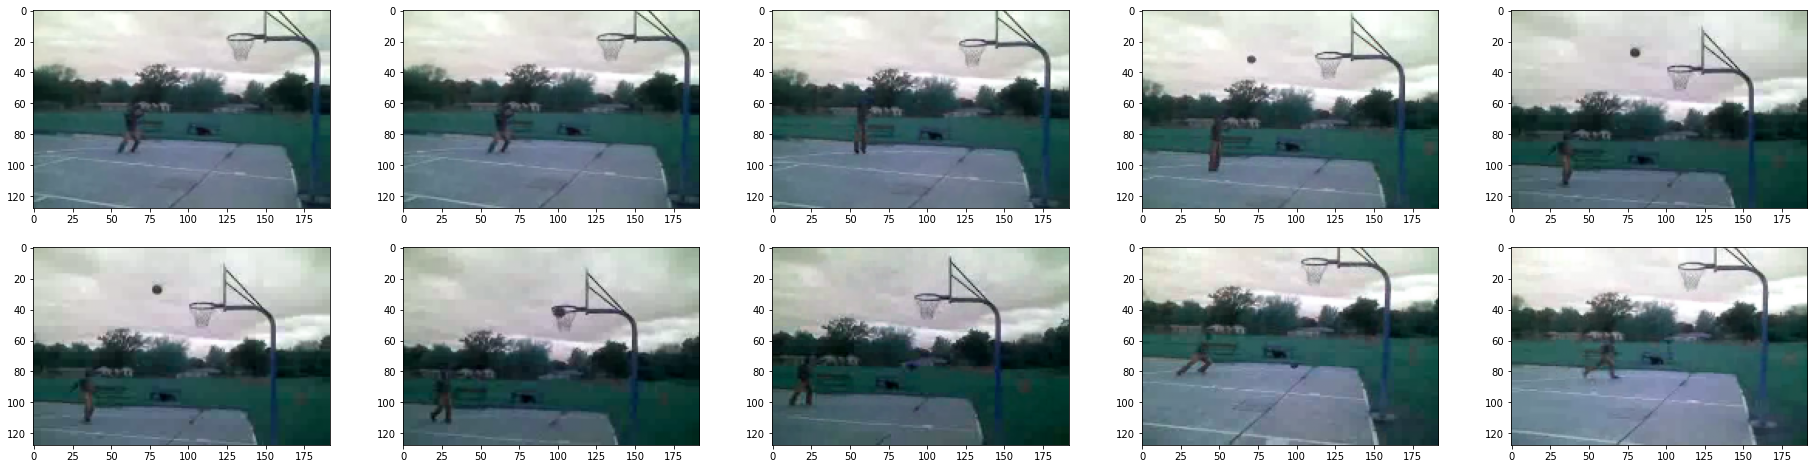

In [14]:
fig = plt.figure(figsize=(32,8))

random_video_index = np.random.randint(0,len(X_frames))

for i,image in enumerate(X_frames[random_video_index]):
    ax = plt.subplot(2,5,i+1)
    imshow(image)

<h1 style="text-align: center"> Building model </h1>

In [15]:
def list_to_stack(xs):
  xs=tf.stack(xs, axis=1)
  s = tf.shape(xs)
 
  return xs

In [16]:
ish=(10, 128, 192, 3)
  
xs=[]


inp = Input(ish)

for slice_indx in range(0,10,1):
  x=Lambda(lambda x: x[:, slice_indx])(inp)
  x=BatchNormalization(momentum=0.8)(x)
  x=Conv2D(filters=20, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
    
  xs.append(x)
  

t=Lambda(list_to_stack)(xs)
t=Conv3D(50,3,padding='same')(t)
t=BatchNormalization(momentum=0.8)(t)
target_shape=(10,32*48*50)
t=Reshape(target_shape)(t)
t=GRU(25, return_sequences=True)(t)
t=GRU(50, return_sequences=False,dropout=0.5)(t)

t=Dense(100,'relu')(t)
out=Dense(10, activation='softmax')(t)

model = Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.SGD(lr=0.0087)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
model.summary()

2023-01-25 11:11:26.861379: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-25 11:11:26.864469: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-25 11:11:26.921228: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-25 11:11:26.921912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2023-01-25 11:11:26.922003: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-01-25 11:11:26.952204: I tensorflow/stream_executor/platform/def

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 128, 192 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 192, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 192, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 128, 192, 3)  0           input_1[0][0]                    
______________________________________________________________________________________________

<p style="font-size: 120%"><b> Model design </b></p>

In [17]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

<p style="font-size: 120%"> <b> Training model </b></p>

In [18]:
history = model.fit(xtr, ytr, epochs=5, batch_size=10,validation_data=(xte, yte),shuffle  = True)

2023-01-25 11:23:44.291929: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1179648000 exceeds 10% of free system memory.
2023-01-25 11:23:45.295450: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-25 11:23:45.305547: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000144999 Hz


Epoch 1/5


2023-01-25 11:23:49.513426: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-25 11:23:50.367874: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-01-25 11:23:50.393505: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


40/40 [==============================] - 16s 131ms/step - loss: 2.1930 - accuracy: 0.2335 - val_loss: 1.9422 - val_accuracy: 0.4800
Epoch 2/5
40/40 [==============================] - 3s 80ms/step - loss: 1.7992 - accuracy: 0.6450 - val_loss: 1.6702 - val_accuracy: 0.6700
Epoch 3/5
40/40 [==============================] - 3s 79ms/step - loss: 1.5568 - accuracy: 0.7811 - val_loss: 1.4232 - val_accuracy: 0.7700
Epoch 4/5
40/40 [==============================] - 3s 80ms/step - loss: 1.3251 - accuracy: 0.8190 - val_loss: 1.1775 - val_accuracy: 0.8600
Epoch 5/5
40/40 [==============================] - 3s 79ms/step - loss: 1.0574 - accuracy: 0.9203 - val_loss: 0.9655 - val_accuracy: 0.8900


<p style="font-size: 120%;"> <b>Training model </b></p>

<h1 style="text-align: center"> Model performance Visualization <h1> 

In [ ]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training loss')
ax.legend(loc="upper left")
plt.ylabel('Loss')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Vallidation loss')
ax.legend(loc="upper left")
fig.suptitle('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
ax.legend(loc="upper left")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], label='Vallidation accuracy')
ax.legend(loc="upper left")
fig.suptitle('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.show()

<h1 style="text-align: center"> Model demonstration </h1> 

<p style="font-size: 120%"> We will take 10 random videos from test set and show predicted activity on them. For demonstration purposes we will show only 1 frame from each video </p>

In [ ]:
classes = []
for i in range(len(content)):
    class_name = content[i].split('/')[0]
    if class_name not in classes:
        classes.append(class_name)
        
num_classes = [i for i in range(10)]
class_map = dict(zip(num_classes,classes))

In [ ]:
random_videos = np.random.randint(0,len(xte),size=(10))
predicted  = model.predict(xte[random_videos],batch_size = 10)
predicted  = np.argmax(predicted,axis=1)

In [ ]:
fig = plt.figure(figsize=(30,10))

for i,rand_indx in enumerate(random_videos):
    ax = plt.subplot(2,5,i+1)
    video = xte[rand_indx]
    frame = video[np.random.randint(0,10)]
    ax.set_title(class_map[predicted[i]])
    imshow(frame)

not perfect as you can see.